<a href="https://colab.research.google.com/github/Gonzalo-Ortega/Stereotypical-Behavior-Classification/blob/main/Analysis_Gonzalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import other libraries and Google Drive

Usefull python libraries:

- Matplotlib: Plotting and data visualization.
- Pandas: Data management. Is most commonly used for data wrangling and data manipulation purposes.
- NumPy: Used to create arrays or matrices that can be applied to DL or ML models.

In [2]:
# Data processing
import pandas as pd
import numpy as np

from scipy.stats import binom
from scipy.special import comb

# Figures
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Data preprocesing and modeling
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Others
import os
import fnmatch
import cv2
import re
import random


from google.colab import files
from typing import List, Tuple


In [3]:
# Mount your Google Drive so the colab its allow to get data from there.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Data analysis**
---


## Load data

In [4]:
def get_video_paths(data_path: str):
  parts = data_path.split('/')
  folder_path = '/'.join(parts[:-1])
  filename = parts[-1].split('_beh-CROPDLC')[0]
  video_path_top = f'{folder_path}/{filename}_beh-CROP.avi'
  video_path_lateral = f'{folder_path}/{filename}_beh-CROP1.avi'
  return video_path_top, video_path_lateral

def load_paths(dir_path):
  h5_paths_top = []
  h5_paths_lateral = []
  video_paths_top = []
  video_paths_lateral = []
  for dirpath, dirs, files in os.walk(dir_path):
    for filename in fnmatch.filter(files, '*CROPDLC_resnet50_DLC_after_injJan5shuffle1_500000.h5'):
      h5_paths_top.append(os.path.join(dirpath, filename))

  for dirpath, dirs, files in os.walk(dir_path):
    for filename in fnmatch.filter(files, '*CROP1DLC_resnet50_DLC-beh-after-inj-lateralJan7shuffle1_600000.h5'):
      h5_paths_lateral.append(os.path.join(dirpath, filename))

  for path in h5_paths_top:
    video_path_top, video_path_lateral = get_video_paths(path)
    video_paths_top.append(video_path_top)
    video_paths_lateral.append(video_path_lateral)
  return h5_paths_top, h5_paths_lateral, video_paths_top, video_paths_lateral

def load_data(h5_paths_top, h5_paths_lateral):
  data_top = []
  data_lateral = []
  for path in h5_paths_top:
    data_top.append(pd.read_hdf(path, header = [1,2,3]))

  for path in h5_paths_lateral:
    data_lateral.append(pd.read_hdf(path, header = [1,2,3]))

  for data in data_top:
    data.columns = list(data.columns.get_level_values(1) + data.columns.get_level_values(2))

    # Invert Y axis:
    data.loc[:, data.columns[data.columns.str.endswith('y')]] = Y_RESOLUTION - data.loc[:, data.columns[data.columns.str.endswith('y')]]

    # Rotate 90 degrees clockwise:
    labels_to_rotate = ['Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
                        'Back_1', 'Back_2', 'Back_3', 'Back_4',
                        'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4']
    for label in labels_to_rotate:
      data = rotate_90_clockwise(data, label)

  for data in data_lateral:
    data.columns = list(data.columns.get_level_values(1) + data.columns.get_level_values(2))

    # Invert Y axis:
    data.loc[:, data.columns[data.columns.str.endswith('y')]] = Y_RESOLUTION - data.loc[:, data.columns[data.columns.str.endswith('y')]]

  return data_top, data_lateral

def rotate_90_clockwise(data, label='') -> pd.DataFrame:
  """
  Rotates all poits from the desired data colum pair (x and y) 90º clockwise to
  align the top view data with the lateral view data.

  Parameters:
  - data (pd.DataFrame): Data to rotate.
  - label (str): Name of the colomns to rotate, without the last 'x' or 'y'.

  Returns:
  - data (pd.DataFrame): Data with the updated rotated column.
  """
  centered_x = data[label + 'x'] - BOX_CENTER['x']
  centered_y = data[label + 'y'] - BOX_CENTER['y']

  coordinates = np.array([centered_x, centered_y])
  rotation_matrix = np.array([[0, 1], [-1, 0]])
  rotated_x, rotated_y = np.dot(rotation_matrix, coordinates)

  data[label + 'x'] = rotated_x + BOX_CENTER['x']
  data[label + 'y'] = rotated_y + BOX_CENTER['y']
  return data


In [5]:
DATA_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/DATA'
FIGURES_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/Colab-figures'
H5_PATHS_TOP, H5_PATHS_LATERAL, VIDEO_PATHS_TOP, VIDEO_PATHS_LATERAL = load_paths(DATA_PATH)

# Y video resolution:
Y_RESOLUTION = 240

# Box coordinates observed from video frames:
BOX_TOP = {'x': [74, 237, 237, 74, 74], 'y': [43, 43, 206, 206, 43]}
BOX_LATERAL = {'x': [94, 24, 310, 258, 283, 81, 94, 258], 'y': [100, 33, 33, 100, 200, 200, 100, 100]}

BOX_CENTER = {'x':(BOX_TOP['x'][0] + BOX_TOP['x'][1]) / 2, 'y':(BOX_TOP['y'][0] + BOX_TOP['y'][3]) / 2}


data_top, data_lateral = load_data(H5_PATHS_TOP, H5_PATHS_LATERAL)


## Auxiliary functions

In [6]:
def info_from_path(video_path) -> dict():
    # Extract Mouse number, date, and video type from the path using regular expressions
    match = re.search(r'Mouse(\d+)_([\d-]+)_.*?beh-(CROP|CROP1)\.avi', video_path)
    if match:
        mouse_number = match.group(1)
        date = match.group(2)
        video_format = 'Top' if match.group(3) == 'CROP' else 'Lateral'
        info_dict = {
            'MouseNumber': mouse_number,
            'Date': date,
            'VideoFormat': video_format
        }
        return info_dict

def get_frame_at_time(video_path, minute, second):
  # Open the video file
  cap = cv2.VideoCapture(video_path)

  # Calculate the frame position based on time
  frame_position = int((minute * 60 + second) * cap.get(cv2.CAP_PROP_FPS))

  # Set the frame position
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)

  # Read the frame at the specified time
  ret, frame = cap.read()

  # Release the video capture object
  cap.release()

  return frame

def get_frame(video_path, frame):
  # Open the video file
  cap = cv2.VideoCapture(video_path)

  # Set the frame position
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame)

  # Read the frame at the specified time
  ret, frame = cap.read()

  # Release the video capture object
  cap.release()

  return frame

def get_mouse_numbers() -> List[int]:
  """
  Gets a list with all the mouse numbers.
  """
  mouse_numbers_list = []
  for path in VIDEO_PATHS_TOP:
    info = info_from_path(path)
    mouse_numbers_list.append(int(info['MouseNumber']))
  return mouse_numbers_list

def get_video_dates() -> List[str]:
  """
  Gets a list with all the video dates.
  """
  video_dates_list = []
  for path in VIDEO_PATHS_TOP:
    info = info_from_path(path)
    video_dates_list.append(info['Date'])
  return video_dates_list

def get_data_frame_latex(data_frame: pd.DataFrame) -> str:
  return data_frame.head(10).to_latex()

def download_figures_zip():
  !zip -r figures.zip $FIGURES_PATH
  files.download('figures.zip')


## Trayectory

In [7]:
def filter_data(data: pd.DataFrame, desired_likelihood: float) -> pd.DataFrame:
  """
  Filters video data removing points whose likelihooed is less than desired and
  adding NaN (np.nan) to its values instead.

  Parameters:
  - data (pd.DataFrame): Data to filter.
  - desired_likelihood (float): Min likelihood each valid point should have.

  Returns:
  - filtered_data (pd.DataFrame): Copy of the original data with not likely
    values changed by NaN (np.nan).
  """

  filtered_data = data.copy()

  parts = [
      'Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
      'Back_1', 'Back_2', 'Back_3', 'Back_4',
      'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4',
      'Paw_left', 'Paw_right'
  ]

  for part in parts:
      likelihood_column = f'{part}likelihood'

      if likelihood_column in filtered_data.columns:
        x_column = f'{part}x'
        y_column = f'{part}y'

        mask = filtered_data[likelihood_column] < desired_likelihood
        filtered_data.loc[mask, [x_column, y_column]] = np.nan

  return filtered_data

def add_means(filtered_data: pd.DataFrame) -> pd.DataFrame:
  """
  Makes a mean with the valid values from the mouse head and adds the 'Meanx'
  and 'Meany' columns to the pd.DataFrame.
  """
  x_coords = np.array([filtered_data[point] for point in ['Nosex', 'Headx', 'Ear_leftx', 'Ear_rightx', 'Neckx']])
  y_coords = np.array([filtered_data[point] for point in ['Nosey', 'Heady', 'Ear_lefty', 'Ear_righty', 'Necky']])

  x_means = np.nanmean(x_coords, axis=0)
  y_means = np.nanmean(y_coords, axis=0)

  filtered_data = filtered_data.assign(Meanx=x_means)
  filtered_data = filtered_data.assign(Meany=y_means)

  return filtered_data

def interpolate_data(filtered_data: pd.DataFrame) -> pd.DataFrame:
  """
  Interpolates NaN (np.nan) values.
  """

  interpolated_data = filtered_data.copy()

  parts = [
      'Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
      'Back_1', 'Back_2', 'Back_3', 'Back_4',
      'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4',
      'Paw_left', 'Paw_right', 'Mean'
  ]

  for part in parts:
    x_column = f'{part}x'
    y_column = f'{part}y'

    if x_column in interpolated_data.columns:
      x_coords = np.array(filtered_data[x_column], dtype=float)
      y_coords = np.array(filtered_data[y_column], dtype=float)

      # Find indices of NaN values
      nan_indices_x = np.isnan(x_coords)
      nan_indices_y = np.isnan(y_coords)

      non_nan_indices = np.arange(len(x_coords))

      # Interpolate NaN values
      if not non_nan_indices[~nan_indices_x].size == 0:
        x_coords[nan_indices_x] = np.interp(non_nan_indices[nan_indices_x], non_nan_indices[~nan_indices_x], x_coords[~nan_indices_x])
        y_coords[nan_indices_y] = np.interp(non_nan_indices[nan_indices_y], non_nan_indices[~nan_indices_y], y_coords[~nan_indices_y])

      interpolated_data[x_column] = x_coords
      interpolated_data[y_column] = y_coords

  return interpolated_data

def check_nan_percentages(part, likelihood):
  part = part + 'likelihood'
  for i in range(len(VIDEO_PATHS_LATERAL)):
    nan_counter = 0
    for row in data_lateral[i][part]:
      if row < likelihood:
        nan_counter += 1

    total = len(filtered_data_lateral[i][part])
    nan_percentage = nan_counter/total*100
    print(f'Video {i}: {nan_percentage:.2f} %')

def filter_and_interpolate(data, desired_likelihood):
  filtered_data = []
  interpolated_data = []

  for data_frame in data:
    filtered_data_frame = filter_data(data_frame, desired_likelihood)
    filtered_data_frame = add_means(filtered_data_frame)
    filtered_data.append(filtered_data_frame)

    interpolated_data_frame = interpolate_data(filtered_data_frame)
    interpolated_data.append(interpolated_data_frame)

  return filtered_data, interpolated_data


In [8]:
def figure_interpolated_trayectory(interpolated_data, video_num):
  data = interpolated_data[video_num]
  video_path = VIDEO_PATHS_LATERAL[video_num]
  info = info_from_path(video_path)
  x = data['Meanx']
  y = data['Meany']
  number = info['MouseNumber']
  date = info['Date']
  format = info['VideoFormat']

  # Interpolated trayectory Figure #
  fig = plt.figure(figsize=(12, 5))
  fig.suptitle(f'{format} trayectory - Video: {video_num}, Mouse: {number}, {date}')

  # Plot 1: Trayectory
  ax1 = fig.add_subplot(121)
  ax1.plot(x, y, label='Position')
  if format == 'Top':
    ax1.plot(BOX_TOP['x'], BOX_TOP['y'], label='Box')
  elif format == 'Lateral':
    ax1.plot(BOX_LATERAL['x'], BOX_LATERAL['y'], label='Box')
  ax1.set_box_aspect(1)
  ax1.spines[['right', 'top']].set_visible(False)
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.legend()

  # Plot 2: Heatmap
  ax2 = fig.add_subplot(122)
  hist = ax2.hist2d(x, y, bins=20)
  cbar = fig.colorbar(hist[3], ax=ax2)
  cbar.set_label('Position frequency')
  ax2.set_box_aspect(1)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')

  fig.savefig(f"{FIGURES_PATH}/trayectory.pdf")

def figure_all_trayectories(data_top, data_lateral):
  # Interpolated trayectory Figure #
  fig = plt.figure(figsize=(12, 5))
  fig.suptitle('All trayectories')

  # Plot 1: All trayectories Top
  ax1 = fig.add_subplot(121)
  for index, data in enumerate(data_top):
    ax1.plot(data['Meanx'], data['Meany'])

  ax1.plot(BOX_TOP['x'], BOX_TOP['y'], label='Box')
  ax1.set_box_aspect(1)
  ax1.spines[['right', 'top']].set_visible(False)
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.set_title('Top trajectories')
  ax1.legend()

  # Plot 2: All trayectories Lateral
  ax2 = fig.add_subplot(122)
  for data in data_lateral:
    ax2.plot(data['Meanx'], data['Meany'])

  ax2.plot(BOX_LATERAL['x'], BOX_LATERAL['y'], label='Box')
  ax2.set_box_aspect(1)
  ax2.spines[['right', 'top']].set_visible(False)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_title('Lateral trajectories')
  ax2.legend()

  fig.savefig(f"{FIGURES_PATH}/all-trayectories.pdf")


In [ ]:
DESIRED_LIKELIHOOD = 0.95
filtered_data_top, interpolated_data_top = filter_and_interpolate(data_top, DESIRED_LIKELIHOOD)
filtered_data_lateral, interpolated_data_lateral = filter_and_interpolate(data_lateral, DESIRED_LIKELIHOOD)

In [ ]:
check_nan_percentages('Paw_left', 0.5)

In [12]:
# figure_all_trayectories(interpolated_data_top, interpolated_data_lateral)
# for video in range(len(VIDEO_PATHS_TOP)):
#   figure_interpolated_trayectory(interpolated_data_top, video)

## Rearing

The mouse will put its weight on its hind legs, raise, it's forelimbs from the ground, and extend it's head upwards.

VARS:
- ``Steady location (position)``
- ``Altitude change	(height)``
- ``Head stretching	(head triangulation, angles)``
- ``Next to the wall (position, ROIs)``

Once the data is filtered, we can use the interpolated head's mean to check if the mouse is rearing by looking where the trayectory goes out of the box limits.

In [13]:
FRAME_RATE = 20
MIN_FRAMES = 5
def get_rearing_intervals(data_frame: pd.DataFrame) -> List[Tuple[int, int]]:
  """
  Gets a list of time intervals where the mouse is rearing in the format:
  '(start_frame, end_frame)'
  """

  # Check frames where trayectory goes out of the box limits.
  out_of_box_frames = set()
  for index, x in enumerate(data_frame['Meanx']):
    if x < BOX_TOP['x'][0] or x > BOX_TOP['x'][1]:
      out_of_box_frames.add(index)

  for index, y in enumerate(data_frame['Meany']):
    if y < BOX_TOP['y'][0] or y > BOX_TOP['y'][3]:
      out_of_box_frames.add(index)

  # Group frames into intervals:
  rearing_intervals_list = []
  start_frame = 0
  last_frame = 0
  out_of_box_frames = list(out_of_box_frames)
  out_of_box_frames.sort()
  for frame in out_of_box_frames:
    if frame != last_frame + 1:
      rearing_intervals_list.append((start_frame, last_frame))
      start_frame = frame
      last_frame = frame
    else:
      last_frame = frame

  # Filter by minumun interval frame amount:
  rearing_intervals_list = [
      (start, end)
      for start, end in rearing_intervals_list if end - start > MIN_FRAMES
  ]

  return rearing_intervals_list

def get_rearing_frames(data_frame: pd.DataFrame) ->  List[Tuple[int, int]]:
  """
    Gets the mid frame of each rearing interval with the format:
    '(min, sec)'
  """
  rearing_intervals = get_rearing_intervals(data_frame)
  rearing_frames = [
      ((start + end)/2 // FRAME_RATE // 60, (start + end)/2 / FRAME_RATE % 60)
      for start, end in rearing_intervals if end - start > MIN_FRAMES
  ]
  return rearing_frames

def get_rearing_times(data_top: List[pd.DataFrame]) -> List[float]:
  """
    Gets a list with the total time the mouse rear in each video.
  """
  rearing_times_list = []
  for data_frame in data_top:
    rearing_intervals = get_rearing_intervals(data_frame)
    total_time = 0
    for start, end in rearing_intervals:
      total_time += (end - start) / FRAME_RATE
    rearing_times_list.append(total_time)
  return rearing_times_list

def get_rearing_amounts(data_top: List[pd.DataFrame]) -> List[int]:
  """
    Gets a list with the number of times the mouse rear in each video.
  """
  rearing_amounts_list = []
  for data_frame in data_top:
    rearing_intervals = get_rearing_intervals(data_frame)
    rearing_amounts_list.append(len(rearing_intervals))
  return rearing_amounts_list


In [14]:
def figure_rearing_frames(data_top, video_number:int):
  rearing_frames = get_rearing_frames(data_top[video_number])

  i = 0
  for minute, second in rearing_frames:
    fig = plt.figure(figsize=(12, 5))
    i += 1
    frame = get_frame_at_time(VIDEO_PATHS_TOP[video_number], minute, second)
    ax1 = fig.add_subplot(1, 2, 1)
    rotated_frame_top = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    ax1.imshow(cv2.cvtColor(rotated_frame_top, cv2.COLOR_BGR2RGB))
    ax1.set_title('Frame {}:{:05.2f}s'.format(int(minute), second))
    ax1.axis('off')

    frame = get_frame_at_time(VIDEO_PATHS_LATERAL[video_number], minute, second)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax2.axis('off')

    plt.tight_layout()
    fig.savefig(f"{FIGURES_PATH}/rearing-{i}.pdf")


In [15]:
# video_number = 5

# figure_interpolated_trayectory(interpolated_data_top, video_number)
# figure_interpolated_trayectory(interpolated_data_lateral, video_number)
# figure_rearing_frames(interpolated_data_top, video_number)

## Body triangulations

In [16]:
def triangulate(data, frame):
  x = []
  y = []
  parts = [
        'Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
        'Back_1', 'Back_2', 'Back_3', 'Back_4',
        'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4']
  for part in parts:
   x.append(data[f'{part}x'][frame])
   y.append(data[f'{part}y'][frame])

  triangles = np.array([
    [0, 1, 2],
    [0, 1, 3],
    [2, 3, 1],
    [2, 3, 4],
    [2, 3, 8]
  ])
  triangulation = tri.Triangulation(x, y, triangles)

  return x, y, triangulation

def triangulate_lateral(data, frame):
  x = []
  y = []
  parts = [
        'Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
        'Back_1', 'Back_2', 'Back_3', 'Back_4',
        'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4',
        'Paw_left', 'Paw_right']
  for part in parts:
   x.append(data[f'{part}x'][frame])
   y.append(data[f'{part}y'][frame])

  triangles = np.array([
    [0, 1, 2],
    [0, 1, 3],
    [2, 3, 1],
    [2, 3, 4],
    [2, 3, 8]
  ])
  triangulation = tri.Triangulation(x, y, triangles)

  return x, y, triangulation


In [17]:
def figure_triangulations_trayectory(data_top, data_lateral):
  fig = plt.figure(figsize=(12, 5))
  fig.suptitle('Triangulation')

  # Plot 1
  ax1 = fig.add_subplot(121)
  for frame in range(1, 5000, 500):
    x, y, triangulation = triangulate(data_top, frame)
    alpha = frame / 5000.0
    ax1.triplot(triangulation, '.--', alpha=alpha)
  ax1.plot(BOX_TOP['x'], BOX_TOP['y'], label='Box')
  ax1.set_box_aspect(1)
  ax1.spines[['right', 'top']].set_visible(False)
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.legend()

  # Plot 2
  ax2 = fig.add_subplot(122)
  for frame in range(1, 5000, 500):
    x, y, triangulation = triangulate(data_lateral, frame)
    alpha = frame / 5000.0
    ax2.triplot(triangulation, '.--', alpha=alpha)
  ax2.plot(BOX_LATERAL['x'], BOX_LATERAL['y'], label='Box')
  ax2.set_box_aspect(1)
  ax2.spines[['right', 'top']].set_visible(False)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.legend()

def figure_triangulation_frame_top(data, video, frame):
  data_frame = data[video]
  frame_img = get_frame(VIDEO_PATHS_TOP[video], frame)
  x, y, triangulation = triangulate(data_frame, frame)

  # Invert frame image
  #frame_img = frame_img[::-1, :, :]

  # Rotate the frame image with the box center rotation center
  #center = (BOX_CENTER['x'], BOX_CENTER['y'])  # Center of rotation
  #angle = -90  # Rotation angle (clockwise)
  #rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
  #frame_img = cv2.warpAffine(frame_img, rotation_matrix, (frame_img.shape[1], frame_img.shape[0]))

  frame_img = cv2.rotate(frame_img, cv2.ROTATE_90_CLOCKWISE)

  fig = plt.figure(figsize=(12, 5))
  ax1 = fig.add_subplot(121)
  ax1.triplot(triangulation, '.--')
  #for i, txt in enumerate(range(len(x))):
  #    ax1.text(x[i], y[i], f'{txt}', ha='right', va='bottom')
  ax1.plot(x[8:], y[8:], '.--')
  ax1.plot(x[4:9], y[4:9], '.--')
  ax1.plot(BOX_TOP['x'], BOX_TOP['y'])

  ax2 = fig.add_subplot(122)
  ax2.imshow(cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB))

  fig.show()

def figure_triangulation_frame_lateral(data, video, frame):
  data_frame = data[video]
  frame_img = get_frame(VIDEO_PATHS_LATERAL[video], frame)
  x, y, triangulation = triangulate_lateral(data_frame, frame)
  fig = plt.figure(figsize=(12, 5))
  ax1 = fig.add_subplot(121)
  ax1.triplot(triangulation, '.--')

  #for i, txt in enumerate(range(len(x))):
  #  ax1.text(x[i], y[i], f'{txt}', ha='right', va='bottom')

  ax1.plot(x[8:13], y[8:13], '.--')
  ax1.plot(x[4:9], y[4:9], '.--')
  ax1.plot(BOX_LATERAL['x'], BOX_LATERAL['y'])

  ax2 = fig.add_subplot(122)
  ax2.imshow(cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB))

  fig.show()


In [18]:
# video = 75
# min, sec = 0, 13
# frame = int((min*60 + sec) * 20)

# figure_triangulations_trayectory(interpolated_data_top[video], interpolated_data_lateral[video])

# for i in range(frame - 20, frame + 20, 5):
#   figure_triangulation_frame_top(interpolated_data_top, video, i)
#   figure_triangulation_frame_lateral(interpolated_data_lateral, video, i)


## Speed and aceleration

In [23]:
def add_time(interpolated_data: pd.DataFrame):
  frame_rate = 20
  time_intervals = interpolated_data['Meanx'].size
  total_time = time_intervals / frame_rate
  time = np.linspace(0, total_time, time_intervals)

  interpolated_data['Time'] = time
  return interpolated_data

def add_speed(interpolated_data: pd.DataFrame):
  dx = np.diff(interpolated_data['Meanx'])
  dy = np.diff(interpolated_data['Meany'])
  speed = np.sqrt(dx**2 + dy**2)
  speed = np.append(speed, speed[-1])
  speed[0] = speed[1]

  interpolated_data['Speed'] = speed
  return interpolated_data

def add_aceleration(interpolated_data: pd.DataFrame):
  aceleration = np.diff(interpolated_data['Speed'])
  aceleration = np.append(aceleration, aceleration[-1])
  aceleration[0] = aceleration[1]

  interpolated_data['Aceleration'] = aceleration
  return interpolated_data

def get_mean_speeds(data_top: List[pd.DataFrame]):
  mean_speeds_list = []
  for data_frame in data_top:
    mean_speeds_list.append(np.mean(data_frame['Speed']))
  return mean_speeds_list

def get_mean_abs_acelerations(data_top: List[pd.DataFrame]):
  mean_abs_acelerations_list = []
  for data_frame in data_top:
    mean_abs_acelerations_list.append(np.mean(abs(data_frame['Aceleration'])))
  return mean_abs_acelerations_list

def get_total_times(data_top: List[pd.DataFrame]):
  total_times_list = []
  for data_frame in data_top:
    total_times_list.append(data_frame['Time'].iloc[-1])
  return total_times_list


In [24]:
def figure_speed_aceleration(interpolated_data, video_num):
  data = interpolated_data[video_num]
  video_path = VIDEO_PATHS_TOP[video_num]
  info = info_from_path(video_path)

  fig = plt.figure(figsize=(12, 5))
  number = info['MouseNumber']
  date = info['Date']
  fig.suptitle(f'Trayectory speed and aceleration - Video: {video_num}, Mouse: {number}, {date}')

  ax1 = fig.add_subplot(121)
  ax1.plot(data['Time'], data['Speed'])
  ax1.set_box_aspect(1)
  ax1.spines[['right', 'top']].set_visible(False)
  ax1.set_xlabel('Time [$s$]')
  ax1.set_ylabel('Speed [$distance/s$]')

  ax1 = fig.add_subplot(122)
  ax1.plot(data['Time'], data['Aceleration'])
  ax1.set_box_aspect(1)
  ax1.spines[['right', 'top']].set_visible(False)
  ax1.set_xlabel('Time [$s$]')
  ax1.set_ylabel('Aceleration [$distance/s^2$]')

  fig.savefig(f"{FIGURES_PATH}/speed-aceleration.pdf")


In [25]:
for data in interpolated_data_top:
  data = add_time(data)
  data = add_speed(data)
  data = add_aceleration(data)

for data in interpolated_data_lateral:
  data = add_time(data)
  data = add_speed(data)
  data = add_aceleration(data)

In [26]:
# video = 5
# figure_speed_aceleration(interpolated_data_top, video)
# figure_speed_aceleration(interpolated_data_lateral, video)

## PCA and Clustering

In [42]:
def initialize_features(data_for_pca):
  features = pd.DataFrame()

  features['Animal_number'] = get_mouse_numbers()[:len(data_for_pca)]
  # features['Date'] = get_video_dates()
  features['Rearing_amount'] = get_rearing_amounts(data_for_pca)
  features['Rearing_time'] = get_rearing_times(data_for_pca)
  features['Mean_speed'] = get_mean_speeds(data_for_pca)
  features['Mean_abs_aceleration'] = get_mean_abs_acelerations(data_for_pca)
  features['Total_time'] = get_total_times(data_for_pca)

  return features

def initialize_assignment_check(features: pd.DataFrame) -> pd.DataFrame:
  animals_treatment = pd.read_csv(DATA_PATH + '/Animals_treatment.csv')
  assignment_check = pd.DataFrame()
  assignment_check['Animal_number'] = features['Animal_number']
  return pd.merge(assignment_check, animals_treatment, on='Animal_number')

def check_assigment(assigment_check, assignment):
  map = assigment_check['Treatment'].map({'CONTROL': 1, 'NMDA': 0})
  return (assignment == map).mean()

def compute_features_pca(features) -> Tuple[np.ndarray, PCA]:
  scaler = StandardScaler()
  scaler.fit(features)
  features_scaled = scaler.transform(features)

  pca = PCA()
  pca.fit(features_scaled)
  features_pca = pca.transform(features_scaled)

  return features_pca, pca

def compute_agg_cluster(features_pca):
  agg = AgglomerativeClustering()
  return agg.fit_predict(features_pca)

def compute_random_cluster(features_pca):
  return [random.choice([0, 1]) for _ in range(len(features_pca))]


In [28]:
def figure_scatter_features_pca(features_pca):
  plt.figure(figsize=(6, 4))
  plt.title('Scatter features after PCA')
  plt.scatter(features_pca[:, 0], features_pca[:, 1])
  plt.gca().set_aspect("equal")
  plt.xlabel("First principal component")
  plt.ylabel("Second principal component")

  plt.savefig(f"{FIGURES_PATH}/scatter-features.pdf")

def figure_color_principal_components(features, pca):
  plt.figure(figsize=(6, 4))
  plt.title('First two principal components')
  plt.matshow(pca.components_[:2], cmap='viridis')
  plt.yticks([0, 1], ["First component", "Second component"])
  plt.colorbar()
  plt.xticks(range(len(features.columns)),
  features.columns, rotation=60, ha='left')
  plt.xlabel("Features")
  plt.ylabel("Principal components")

  plt.savefig(f"{FIGURES_PATH}/color-principal-components.pdf")

def figure_scatter_agglomerative_clusterig(features_pca, assignment):
  plt.figure(figsize=(6, 4))
  plt.scatter(features_pca[:, 0], features_pca[:, 1], c=assignment, cmap='viridis', alpha=0.5)
  plt.xlabel("First principal component")
  plt.ylabel("Second principal component")
  plt.title("Agglomerative Clustering Results")

  plt.savefig(f"{FIGURES_PATH}/agglomerative-clustering.pdf")

def figure_pca_explained_variance(pca):
  acum_variance = pca.explained_variance_ratio_.cumsum()
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
  ax1.bar(
      x      = np.arange(pca.n_components_) + 1,
      height = pca.explained_variance_ratio_
  )

  for x, y in zip(np.arange(len(features.columns)) + 1, pca.explained_variance_ratio_):
      label = round(y, 2)
      ax1.annotate(
          label,
          (x,y),
          textcoords="offset points",
          xytext=(0,10),
          ha='center'
      )

  ax1.set_xticks(np.arange(pca.n_components_) + 1)
  ax1.set_ylim(0, 1.1)
  ax1.set_title('Explained variance explained by each component')
  ax1.set_xlabel('Principal component')
  ax1.set_ylabel('Explained variance percentage')

  ax2.plot(
      np.arange(len(features.columns)) + 1,
      acum_variance,
      marker = 'o'
  )

  for x, y in zip(np.arange(len(features.columns)) + 1, acum_variance):
      label = round(y, 2)
      ax2.annotate(
          label,
          (x,y),
          textcoords="offset points",
          xytext=(0,10),
          ha='center'
      )

  ax2.set_ylim(0, 1.1)
  ax2.set_xticks(np.arange(pca.n_components_) + 1)
  ax2.set_title('Acum. explained variance percentage')
  ax2.set_xlabel('Principal component')
  ax2.set_ylabel('Acum. variance percentage')

  plt.savefig(f"{FIGURES_PATH}/explained-pca-variance.pdf")

def figure_binomial_dist(n=100, p=0.5):
  # Generate x values (number of successes)
  x = np.arange(0, n+1)

  # Calculate the binomial probability mass function (PMF) for each x
  pmf_values = binom.pmf(x, n, p)

  # Plot the binomial distribution
  plt.figure(figsize=(6, 4))
  plt.plot(x, pmf_values)
  plt.title('Binomial Distribution')
  plt.xlabel('Number of Successes')
  plt.ylabel('Probability')
  xticks = np.arange(0, 100, 10)
  plt.xticks(xticks)
  plt.savefig(f"{FIGURES_PATH}/binomial-distribution.pdf")
  plt.show()

def figure_cumulative_binomial_dist(n=100, p=0.5):
  x = np.arange(0, n+1)
  cdf_values = binom.cdf(x, n, p)

  # Plot the cumulative binomial distribution
  plt.figure(figsize=(6, 4))
  plt.plot(x, 1- cdf_values)
  plt.plot([57, 57], [0,0.85], label='Archived success: 57%')
  intersection_probability = cdf_values[np.where(x == 57)[0][0]]
  plt.plot(57, 1-binom.cdf(57, n, p), marker='x', label='0.0666')


  plt.title('Inverse Cumulative Binomial Distribution')
  plt.xlabel('Successes percentage')
  plt.ylabel('Inverse cumulative probability')
  plt.legend()
  plt.savefig(f"{FIGURES_PATH}/inverse-cumulative-binomial-distribution.pdf")
  plt.show()


In [ ]:
features = initialize_features(interpolated_data_top)
features_pca, pca = compute_features_pca(features)
assignment = compute_agg_cluster(features_pca)
# assignment = compute_random_cluster(features_pca)

assignment_check = initialize_assignment_check(features)
check_assigment(assignment_check, assignment)


In [44]:
# figure_scatter_features_pca(features_pca)
# figure_color_principal_components(features, pca)
# figure_pca_explained_variance(pca)

# figure_scatter_agglomerative_clusterig(features_pca, assignment)
# figure_binomial_dist()
# figure_cumulative_binomial_dist()

## Method testing

In [31]:
def compute_method_distribution(features: pd.DataFrame, sesions=50, iterations=1000) -> List[float]:
  dist = []
  for i in range(iterations):
    features_sample = features.sample(n=sesions)
    features_pca, pca = compute_features_pca(features_sample)
    assignment = compute_agg_cluster(features_pca)
    assignment_check = initialize_assignment_check(features_sample)
    dist.append(check_assigment(assignment_check, assignment))
  return dist

In [34]:
def figure_method_dist(dist_values: List[float]):
  hist, edges = np.histogram(dist_values, bins=50, range=(0, 1))
  quantiles = np.quantile(dist_values, [0.025, 0.5, 0.975])

  hist = hist / len(dist_values)

  plt.figure(figsize=(6, 4))
  # plt.bar(edges[:-1], hist, width=0.01, color='grey')

  plt.plot([quantiles[0], quantiles[0]], [0, 0.1], label='0.025 quantile')
  plt.plot([quantiles[1], quantiles[1]], [0, 0.1], label='Median')
  plt.plot([quantiles[2], quantiles[2]], [0, 0.1], label='0.975 quantile')

  plt.plot(edges[:-1], hist, marker='', linestyle='-')

  plt.title('Method Distribution')
  plt.xlabel('Success proportion')
  plt.ylabel('Probability')
  xticks = np.arange(0, 1.1, 0.1)
  plt.xticks(xticks)
  plt.legend()

  plt.savefig(f"{FIGURES_PATH}/method-distribution.pdf")
  plt.show()

In [32]:
dist = compute_method_distribution(features, iterations=1000)


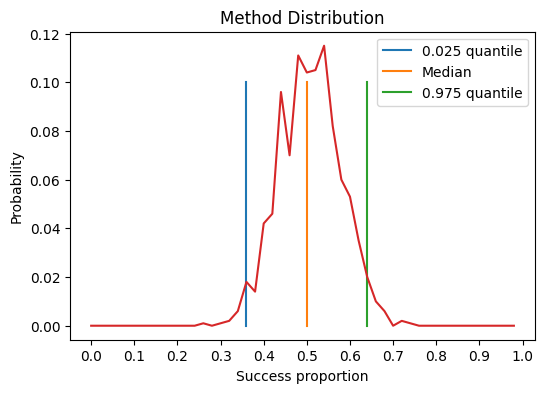

In [35]:
figure_method_dist(dist)